# Q5: Global idea: To what extent is a movie's success influenced by its director?

## Import libraries

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from ipywidgets import interact, widgets
from IPython.display import clear_output

## Load the data

In [37]:
df=pd.read_csv('../data/movies_combined_inflated.csv')


In [38]:
df['release_year'].max()

np.float64(2016.0)

## 0. Initial analysis

In [39]:
sns.set_palette("blend:#7AB,#EDA") 
custom_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2"]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

- What is the highest inflated revenue each year?
- Which directors generate the most revenue?
- Which directors produce the most movies?
- Who generated the best average revenue per movie?

### 0.1 What is the highest inflated revenue each year?

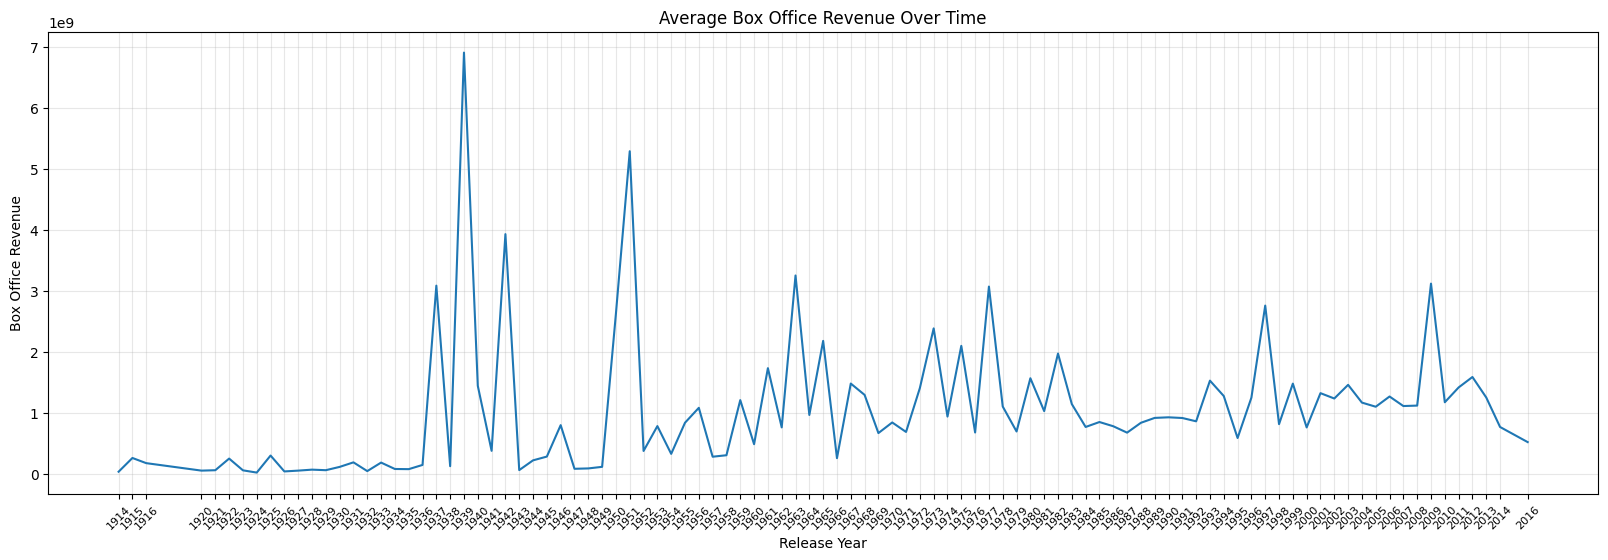

In [40]:
plt.figure(figsize=(20, 6))
yearly_inflated_avg = df.groupby("release_year")["inflated_revenue"].max()
sns.lineplot(x=yearly_inflated_avg.index, y=yearly_inflated_avg.values)
plt.title("Average Box Office Revenue Over Time")
plt.xlabel("Release Year")
plt.ylabel("Box Office Revenue")
plt.xticks(yearly_inflated_avg.index, rotation=45,fontsize=8)
plt.grid(True, alpha=0.3)
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - We can see that the highest inflated revenue movie is in 1939
</div>

In [41]:
df_dir=df[['director','inflated_revenue','release_year','title']]
#df_dir=df_dir[df_dir['director']!='Unknown']
df_dir[df_dir['inflated_revenue']==df_dir['inflated_revenue'].max()]

,director,inflated_revenue,release_year,title
4499,Victor Fleming,6.905588e+09,1939.0,Gone with the Wind


### 0.2 Which directors generate the most revenue?

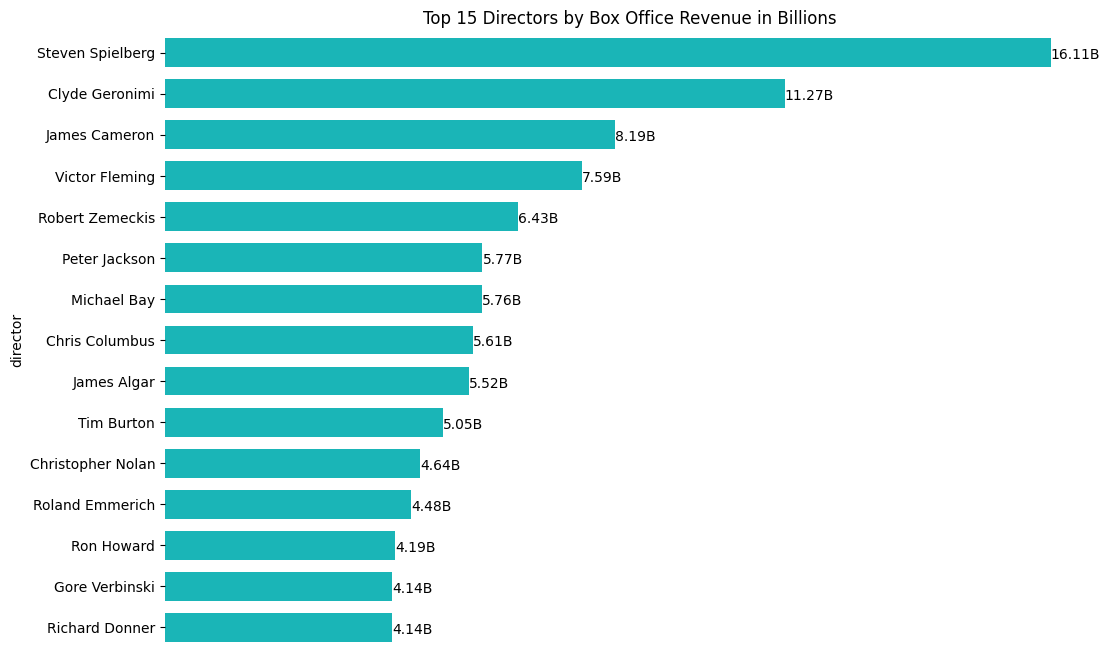

In [42]:
df_dir=df_dir[df_dir['director']!='Unknown']
df_top_dir=df_dir.groupby('director').sum().sort_values(by='inflated_revenue',ascending=False).head(15)
df_top_dir.reset_index(inplace=True)
plt.figure(figsize=(12, 8))
ax=sns.barplot(y='director',x='inflated_revenue',data=df_top_dir, width=0.7, color='#00CED1')
# hide x axis
ax.xaxis.set_visible(False)
# put the inflated revenue on the right side of the bar in billions
ax.set_title("Top 15 Directors by Box Office Revenue in Billions")
for i in ax.patches:
    ax.text(i.get_width()+0.5, i.get_y()+0.5, str(round(i.get_width()/1e9,2))+'B', fontsize=10, color='black')
plt.box(False)


### 0.4 Which directors produce the most movies?

/tmp/ipykernel_18853/2854513672.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(x=df_count.index,y=df_count.values,palette='viridis')


Text(0.5, 1.0, 'Top 15 Directors by Number of Movies')

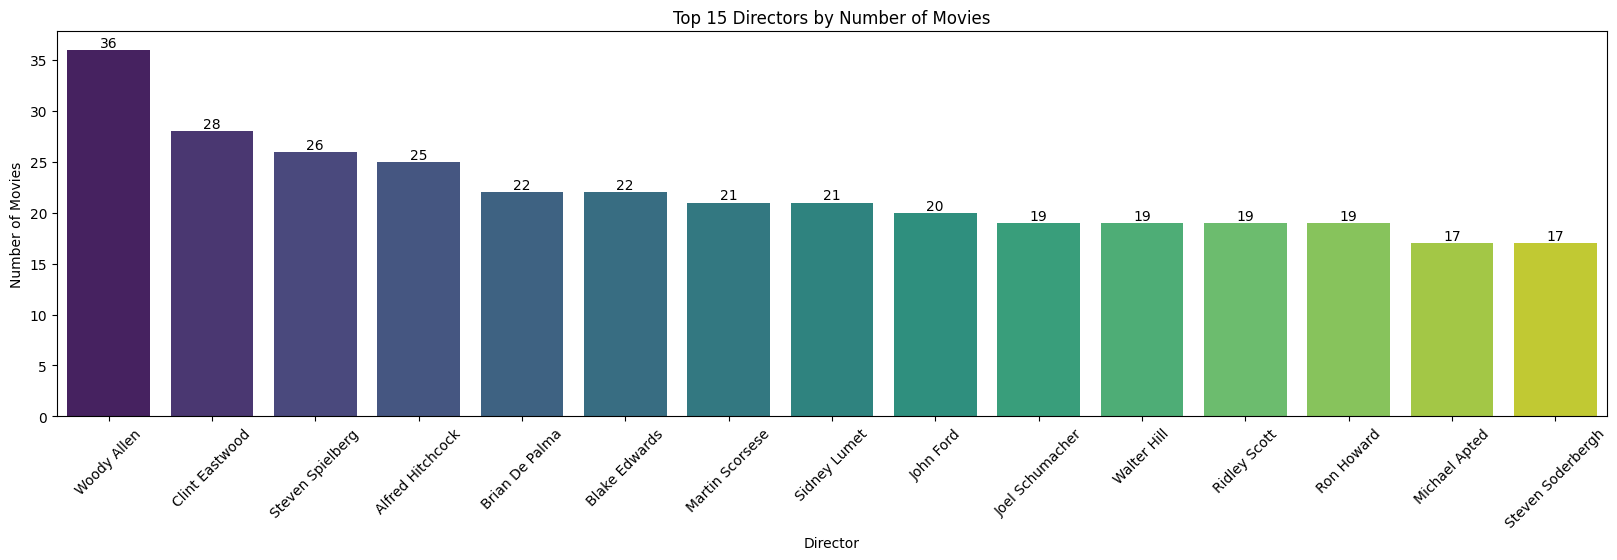

In [43]:
# plot top 10 directors by number of movies
df_count=df_dir['director'].value_counts().head(15)
plt.figure(figsize=(20,5))
# add numbers above bars
ax=sns.barplot(x=df_count.index,y=df_count.values,palette='viridis')
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=45)
plt.xlabel('Director')
plt.ylabel('Number of Movies')
plt.title('Top 15 Directors by Number of Movies')


### 0.5 Who generated the best average revenue per movie?

/tmp/ipykernel_18853/433026370.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(x=df_mean.index,y=df_mean['inflated_revenue'],palette='viridis')


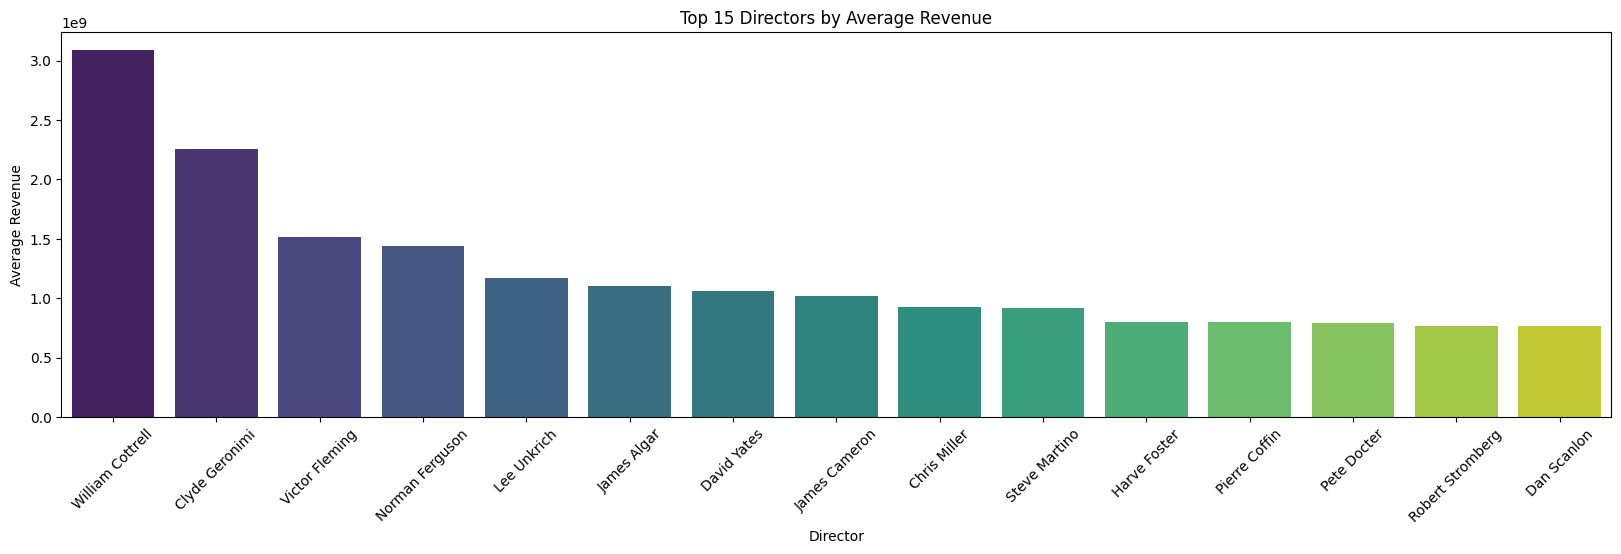

In [44]:
# plot top 15 revenue generating directors average revenue
df_mean=df_dir[['director','inflated_revenue']].groupby('director').mean().sort_values(by='inflated_revenue',ascending=False).head(15)
plt.figure(figsize=(20,5))
# add numbers above bars
ax=sns.barplot(x=df_mean.index,y=df_mean['inflated_revenue'],palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Director')
plt.ylabel('Average Revenue')
plt.title('Top 15 Directors by Average Revenue')
plt.show()

## 1. Analysis

### 1.1 Is each year's highest revenue movie directed by the same director?

/tmp/ipykernel_18853/3456678886.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dir_reduced_year['release_year'] = df_dir_reduced_year['release_year'].astype(int)
/tmp/ipykernel_18853/3456678886.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_top = df_dir_reduced_year.groupby('release_year').apply(lambda x: x.nlargest(top, 'inflated_revenue')).reset_index(drop=True)


<Figure size 2000x1500 with 0 Axes>

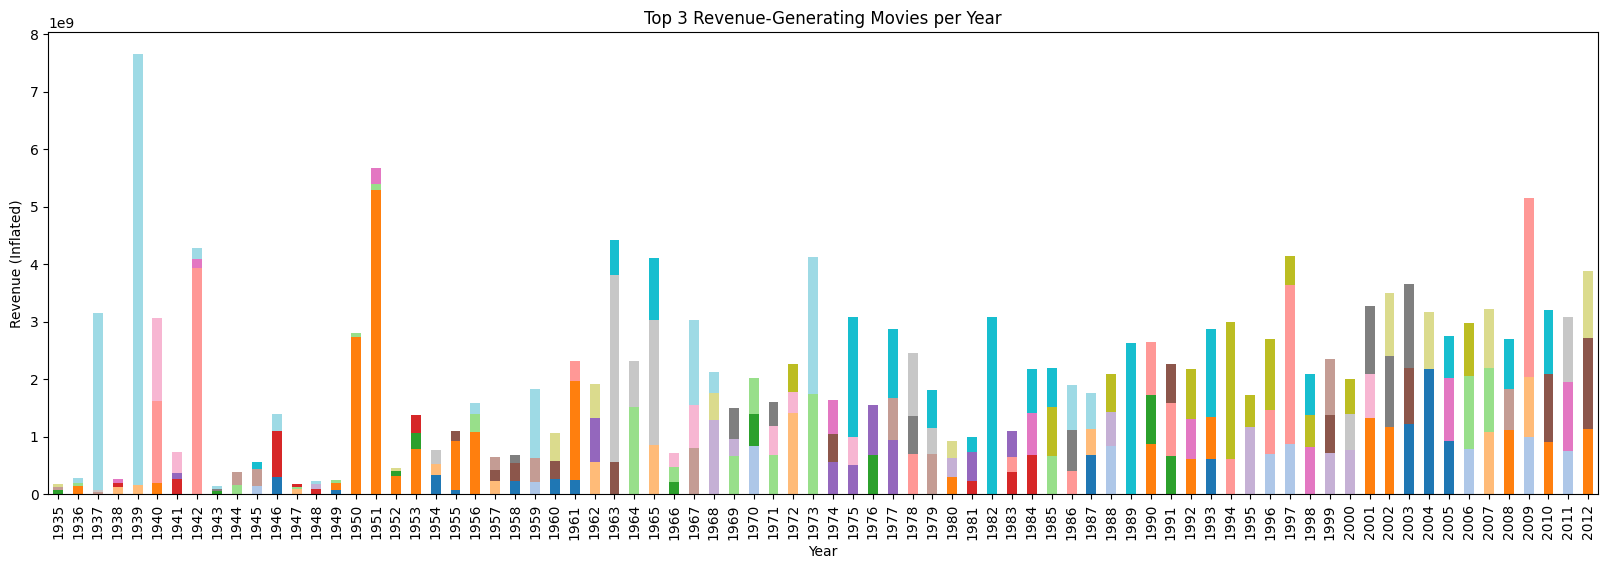

In [45]:
# Group by year and get the top 3 movies by revenue per year without sorting
df_dir_reduced_year = df_dir[(df_dir['release_year'] >= 1935) & (df_dir['release_year'] <= 2012)] # cleaner data
df_dir_reduced_year['release_year'] = df_dir_reduced_year['release_year'].astype(int)
top = 3
df_top = df_dir_reduced_year.groupby('release_year').apply(lambda x: x.nlargest(top, 'inflated_revenue')).reset_index(drop=True)

# Grouping and preparing data for plotting
yearly_director_revenue = df_top.groupby(['release_year', 'director'])['inflated_revenue'].sum().unstack(fill_value=0)
# For each year I want the to get the director with the highest revenue and sort the columns by that
# Code Here
# Find the top director per year (the one with the highest revenue)
top_director_per_year = yearly_director_revenue.idxmax(axis=1)


# Plotting
plt.figure(figsize=(20, 15))

# Prepare the data for plotting: reorder so that the top director's revenue comes first
yearly_director_revenue_sorted = yearly_director_revenue.apply(
    lambda row: row.sort_values(ascending=False), axis=1)

# Plotting with stacked bars
ax = yearly_director_revenue_sorted.plot(kind='bar', stacked=True, figsize=(20, 6), cmap='tab20')


# Customize the plot
plt.title(f'Top {top} Revenue-Generating Movies per Year')
plt.xlabel('Year')
plt.ylabel('Revenue (Inflated)')

# Remove the legend
ax.legend().remove()

plt.show()


<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - Tried to do a interactive plot to show the highest revenue movie each year and its director. But not sure it is the best way to show this information.
</div>


In [46]:
# Aggregate revenue by year and director
df_dir_reduced_year=df_dir[(df_dir['release_year']>=1935) &(df_dir['release_year']<=2012)].sort_values(by='inflated_revenue',ascending=False)
df_dir_reduced_year['release_year']=df_dir_reduced_year['release_year'].astype(int)
top=1
df_top = df_dir_reduced_year.groupby('release_year').apply(lambda x: x.nlargest(top, 'inflated_revenue')).reset_index(drop=True)
yearly_director_revenue = df_top.pivot_table(index='release_year', columns='director', values='inflated_revenue', fill_value=0)

# List of all directors for dropdown options
directors = yearly_director_revenue.columns.tolist()

# Define a function to create and display the plot
def update_plot(selected_director):
    fig = go.Figure()

    # Colors: Highlight selected director, gray for others
    base_color = "lightgray"
    selected_color = "royalblue"
    
    for director in yearly_director_revenue.columns:
        color = selected_color if director == selected_director else base_color
        fig.add_trace(go.Bar(
            x=yearly_director_revenue.index,
            y=yearly_director_revenue[director],
            name=director,
            marker_color=color
        ))
    
    # Update layout for aesthetics
    fig.update_layout(
        barmode='stack',
        title=f'Cumulative Revenue by Year - Highlighted: {selected_director}',
        xaxis_title="Year",
        yaxis_title="Revenue (Inflated)",
        legend_title="Director",
        xaxis=dict(tickmode='array', tickvals=[year for year in yearly_director_revenue.index if year % 10 == 0])  # Show every 10 years
    )
    fig.show()

/tmp/ipykernel_18853/1046061664.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_top = df_dir_reduced_year.groupby('release_year').apply(lambda x: x.nlargest(top, 'inflated_revenue')).reset_index(drop=True)


In [47]:
# Create interactive dropdown widget for selecting a director
director_dropdown = widgets.Dropdown(
    options=directors,
    description="Director:",
    value=directors[0]
)

# Link the dropdown to the update_plot function
interact(update_plot, selected_director=director_dropdown)


interactive(children=(Dropdown(description='Director:', options=('Adrian Lyne', 'Alfred Hitchcock', 'Andrew Ad…

<function __main__.update_plot(selected_director)>

<div class="alert alert-success">

  💭 <strong> Other ideas: </strong>
  
  - Should we plot an interactive plot that shows the progression of the director's revenue over the years?
  
</div>